In [1]:
%pip install -Uq chromadb numpy datasets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires ptxcompiler, which is not installed.
cuml 24.4.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.1 which is incompatible.
cudf 24.4.1 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.5.0 which

In [2]:
# Imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
import spacy
import pandas as pd
import numpy as np
import os
import pickle
import re
import random
from tqdm import tqdm
from PIL import Image
import math
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from transformers import AutoModel, AutoTokenizer

import chromadb

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
# Save checkpoint
def save_checkpoint(state,filename='weights.pth.tar'):
    print('Saving weights-->')
    torch.save(state,filename)

# Load checkpoint
def load_checkpoint(filename,model,optim):
    print('Loading weights-->')
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

In [5]:
def create_dataframe(BASE_PATH,json_file,image_folder):
    path = os.path.join(BASE_PATH,"annotations/"+json_file)
    with open(path) as f:
        data = json.load(f)
        data = data['annotations']

    img_cap_pairs = []

    for sample in data:
        img_name = '%012d.jpg' % sample['image_id']
        img_cap_pairs.append([img_name, sample['caption']])

    captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
    captions['image'] = captions['image'].apply(
        lambda x: f'{BASE_PATH}/{image_folder}/{x}'
    )
    captions = captions.reset_index(drop=True)
    return captions

In [6]:
train_df = create_dataframe("/kaggle/input/coco-2017-dataset/coco2017","captions_train2017.json","train2017")
val_df = create_dataframe("/kaggle/input/coco-2017-dataset/coco2017","captions_val2017.json","val2017")

In [7]:
train_df.head()

,image,caption
0,/kaggle/input/coco-2017-dataset/coco2017/train...,A bicycle replica with a clock as the front wh...
1,/kaggle/input/coco-2017-dataset/coco2017/train...,A room with blue walls and a white sink and door.
2,/kaggle/input/coco-2017-dataset/coco2017/train...,A car that seems to be parked illegally behind...
3,/kaggle/input/coco-2017-dataset/coco2017/train...,A large passenger airplane flying through the ...
4,/kaggle/input/coco-2017-dataset/coco2017/train...,There is a GOL plane taking off in a partly cl...


In [8]:
# Visualize the images
def visualize_image(dataframe, idx):
    image_path = dataframe['image'][idx]
    image = Image.open(image_path)

    # Define the title
    title = dataframe['caption'][idx]

    # Display the image with the title
    plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
    plt.imshow(image)
    plt.title(title, fontsize=10)  # Adjust the font size as needed
    plt.axis('off')  # Hide axes
    plt.show()

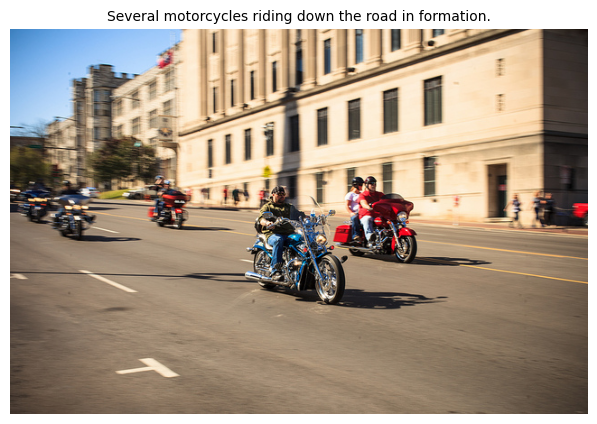

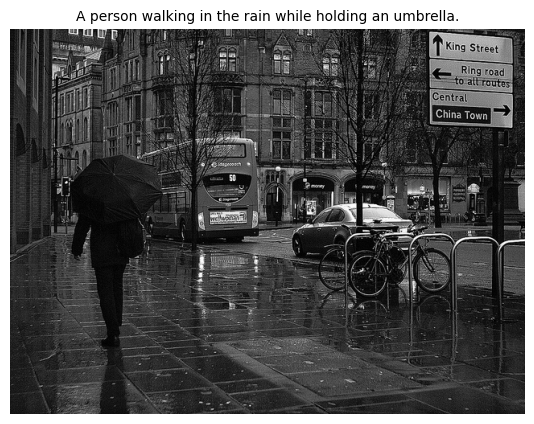

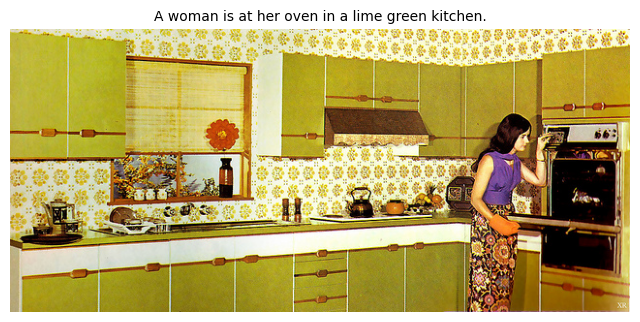

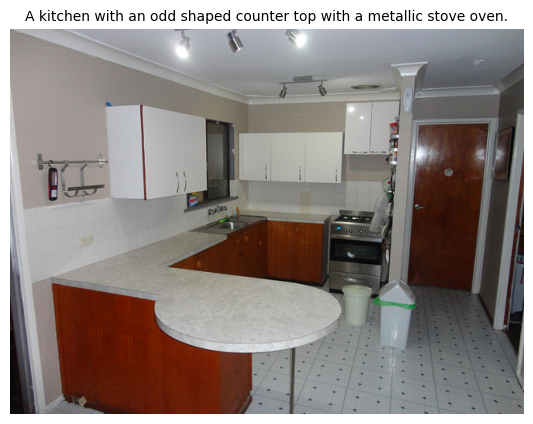

In [9]:
for idx in [20,98,654,1986]:
    visualize_image(train_df, idx)

In [10]:
# Define the custom dataset for MSCOCO

class CocoDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.dataframe = dataframe
        self.image_transform = image_transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image_path = self.dataframe['image'][idx]
        caption = self.dataframe['caption'][idx]

        image = Image.open(image_path).convert("RGB")

        if self.image_transform:
            image = self.image_transform(image)

        return {"image": image, "caption": caption}

In [11]:
# Create transform
transform =transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])

In [12]:
# Create train & val dataloaders 
train_dataset = CocoDataset(train_df, transform)
val_dataset = CocoDataset(val_df, transform)

In [13]:
# Define Embedding Mapping head for Image Encoder and Text Encoder
# this is the guy who will be trained to map images & texts to common embedding space

class EmbeddingMapper(nn.Module):
    def __init__(self, dim_in, dim_out, dropout = 0.3):
        super(EmbeddingMapper, self).__init__()
        self.linear1 = nn.Linear(dim_in, dim_out, bias=False)
        self.linear2 = nn.Linear(dim_out, dim_out, bias=False)
        self.layer_norm = nn.LayerNorm(dim_out)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inputs):
        # input shape : [B X dim_in]
        inputs1 = self.linear1(inputs)
        # input1 shape : [B X dim_out]
        inputs2 = self.dropout(self.linear2(self.dropout(F.gelu(inputs1))))
        # input2 shape : [B X dim_out]
        return self.layer_norm(inputs1 + inputs2)

In [14]:
# custom loss using cross entropy loss function

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, similarities):
        n = similarities.shape[1]

        # Create labels tensor
        labels = torch.arange(n,device=similarities.device)

        # Calculate cross entropy loss
        loss = F.cross_entropy(similarities, labels)

        return loss

In [15]:
# check accuracy function

def check_accuracy(similarities):
    n = similarities.shape[1]
    y = torch.arange(n).to(similarities.device)
    img2cap_match_idx = similarities.argmax(dim=1)
    img_acc = (img2cap_match_idx == y).float().mean()

    return img_acc

In [16]:
# Define image embedding extractor - can be any SOTA CNN - Resnet50, ViT etc

class ImageEmbeddingExtractor(nn.Module):
    def __init__(self, out_dim = 512):
        super(ImageEmbeddingExtractor, self).__init__()
        self.base = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT) # last layer is a linear layer with out_dim = 1000
        self.embeddingmapper = EmbeddingMapper(dim_in = 1000, dim_out = out_dim)
        # freeze weights of base model
        for layer in self.base.parameters():
            layer.requires_grad = False
            
    def forward(self, images):
        # images shape : [B X C X H X W]
        inputs1 = self.base(images)
        # inputs1 shape : [B X 1000]
        embeddings = self.embeddingmapper(inputs1)
        # embeddings shape : [B X out_dim]
        embeddings_len = torch.linalg.norm(embeddings, dim=-1).unsqueeze(dim=1)
        return embeddings/embeddings_len # convert to unit vectors

In [17]:
# Define text embedding extractor - can be any transformer architecture - Autoregressive(GPT-like) or Autoencoding(Bert-like)

class TextEmbeddingExtractor(nn.Module):
    def __init__(self, device, out_dim = 512):
        super(TextEmbeddingExtractor, self).__init__()
        self.base_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
        self.base = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
        self.embeddingmapper = EmbeddingMapper(dim_in = 384, dim_out = out_dim)
        self.device = device
        # freeze weights of base model
        for layer in self.base.parameters():
            layer.requires_grad = False
    
    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, captions):
        # captions : raw sentences
        encoded_input = self.base_tokenizer(captions, padding=True, truncation=True, return_tensors='pt').to(self.device)
        # encoded_input - contains tokens, attention mask, input_ids
        model_output = self.base(**encoded_input)
        # model_output - contains last hidden state of model
        pooled_outputs = self.mean_pooling(model_output, encoded_input['attention_mask'])
        embeddings = self.embeddingmapper(pooled_outputs)
        # embeddings shape : [B X out_dim]
        embeddings_len = torch.linalg.norm(embeddings, dim=-1).unsqueeze(dim=1)
        # or can use
        # unit_embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings/embeddings_len # convert to unit vectors

In [18]:
class CLIP_like(nn.Module):
    def __init__(self, device, embedding_dim=512):
        super(CLIP_like, self).__init__()
        self.embedding_dim = embedding_dim
        self.device = device
        self.image_encoder = ImageEmbeddingExtractor(self.embedding_dim)
        self.text_encoder = TextEmbeddingExtractor(device, self.embedding_dim)
        
    def forward(self, images = None, text = None):
        image_embeddings,text_embeddings, similarity = None,None,None
        # image tensors, raw text
        
        if images!=None:
            image_embeddings = self.image_encoder(images)
        # image embeddings shape - [B X embedding_dim]
        
        if text!=None:
            text_embeddings = self.text_encoder(text)
        # text embeddings shape - [B X embedding_dim]
        
        if images!=None and text!=None:
            similarity = image_embeddings @ text_embeddings.T
        # similary matrix shape : [B X B] - represents similarity scores
        # only elements in on the principal diag i.e [1,1] , [2,2] , [3,3] ... should be nearing one
        # all other elements should be zero
        return similarity, image_embeddings, text_embeddings

In [19]:
# Params
embedding_dim = 512
num_epochs = 5
num_workers = 4
learning_rate = 0.0001
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 8
load_weights = True

In [20]:
model = CLIP_like(device)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

1234944


In [21]:
# Specify optimizer and LR scheduler
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [22]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [23]:
data = next(iter(train_loader))

In [24]:
data['image'].shape

torch.Size([8, 3, 512, 512])

In [25]:
data['caption']

['Cute little dog in goggles and life vest riding a surfboard',
 'display of colors in red, browns,green,black gold blue and yellow',
 'An elephant is led around by a trainer.',
 'A blue motorcycle parked in front of two garage doors.',
 'one person sitting on a couch holding a guitar next to three other people in a living room.',
 'A high rise store front opening is closed and covered with fence.',
 'A man cross-country skiing on a clear day.',
 'Group of women sitting around a dinner table eating. ']

In [26]:
data['image'] = data['image'].to("cuda")
print()

In [27]:
model = model.to("cuda")
print()

In [28]:
# You HAVE to load weights for optim after moving model to cuda, cause Adam optim objects are loaded differntly for cuda & cpu. & cuase error on training
if load_weights:
    weights_path = "/kaggle/working/weights.pth.tar"
    load_checkpoint(weights_path,model,optimizer)

Loading weights-->


In [39]:
similarity, _, _ = model(data['image'],data['caption'])

In [40]:
similarity.shape

torch.Size([8, 8])

In [41]:
def train_loop(model,dataloader,loss_fun,optimizer,scheduler,device):
    model.train()
    model.to(device)
    min_loss = None
    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
        for batch,data in loop:
            images = data['image']
            text = data['caption']
            # put on cuda
            images = images.to(device)
    
            # forward pass
            similarities,_,_ = model(images,text)
            
            # calculate loss & accuracy
            loss = loss_fun(similarities)
            losses.append(loss.detach().item())
            
            accuracy = check_accuracy(similarities)
            accuracies.append(accuracy.detach().item())
            
            # zero out prior gradients
            optimizer.zero_grad()
            
            # backprop
            loss.backward()
            
            # update weights
            optimizer.step()
            scheduler.step()
            
            # Update TQDM progress bar
            loop.set_description(f"Epoch [{epoch}/{num_epochs}] ")
            loop.set_postfix(loss=loss.detach().item(), accuracy=accuracy.detach().item())

        moving_loss = sum(losses) / len(losses)
        moving_accuracy = sum(accuracies) / len(accuracies)
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        # Save check point
        if min_loss == None:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        elif moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        print('Epoch {0} : Loss = {1} , Training Accuracy={2}'.format(epoch, moving_loss, moving_accuracy))

In [ ]:
train_loop(model,train_loader,criterion,optimizer,scheduler,device)

Epoch [4/5] :  96%|█████████▋| 71361/73970 [1:54:18<04:09, 10.46it/s, accuracy=0.875, loss=1.36]  

In [37]:
def test_loop(model,dataloader,optimizer,scheduler,device):
    model.eval()
    model.to(device)
    losses = []
    samples,correct = 0,0
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for batch,data in loop:
            images = data['image']
            text = data['caption']
            
            # put on cuda
            images = images.to(device)
    
            # forward pass
            similarities, _, _ = model(images,text)

            # accuracy over entire dataset
            num_samples = similarities.shape[0]
            samples += num_samples
            y = torch.arange(num_samples).to(device)
            img2cap_match_idx = similarities.argmax(dim=1)
            correct += (img2cap_match_idx == y).sum().item()

    print("Final Test Accuracy = ",100 * (correct/samples))

In [38]:
test_loop(model,val_loader,optimizer,scheduler,device)

100%|██████████| 3127/3127 [04:33<00:00, 11.45it/s]

Final Test Accuracy =  64.96761813384505


### Problem
Generating embeddings & storing using pickle files leads to exhaustion of RAM due to ever growing list of embeddings.

### Solution
Use Chroma DB

In [39]:
# Generate & store image
def create_image_embeddings(model,dataframe,device,collection):
    # Put model to evat
    model.eval()
    model.to(device)
        
    transform =transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor()
    ])
    
    index = 0

    for image_path in dataframe['image']:
        # open image & preprocess
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0)
        
        # move to cuda
        image_tensor = image_tensor.to(device)
        
        # forward prop
        _, image_embedding, _ = model(image_tensor)
        
        # insert to Chroma DB
        collection.add(ids = [str(index)], embeddings=image_embedding.tolist(), metadatas=[{"image_path": image_path}])
        
        index += 1  

In [40]:
chroma_client = chromadb.PersistentClient(path="/kaggle/working/")
collection_name = "image_embedding"
collection = chroma_client.get_or_create_collection(collection_name, metadata={"hnsw:space": "cosine"})

In [ ]:
create_image_embeddings(model,train_df,device,collection)